In [1]:
# Uncomment line below if LOAD_PATH returns only 2
push!(LOAD_PATH,"/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers");
# Uncomment line below if PyPlot isn't installed in you v0.6.0 .julia environment 
#   This system assumes usage of Python2.7 in your .julia environment
# Pkg.add("PyPlot")
# LOAD_PATH

In [2]:
# Push local directory to get access to GradientModels
push!(LOAD_PATH,pwd());

In [3]:
LOAD_PATH

4-element Array{Any,1}:
 "/Applications/Julia-0.6.app/Contents/Resources/julia/local/share/julia/site/v0.6"
 "/Applications/Julia-0.6.app/Contents/Resources/julia/share/julia/site/v0.6"      
 "/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers"                              
 "/Users/ilanfilonenko/sgd-vr-precision/experiments"                               

In [4]:
# Update packages
# Pkg.update();

In [5]:
using PyPlot

In [6]:
using GradientModels

In [7]:
using FixedPointNumbers

In [8]:
# Data Generation
srand(424242)
d = 200;
N = 1000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2, 2));
Y = (1 ./ (1 + exp.(-X * wtrue)) .>= rand(N)) * 2 - 1;
gamma = 100.0
# find the true minimum
function newton_logreg(w0, X, Y, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 + exp.(Y .* (X * w)))) + N * gamma * w;
        H = X' * ((1 ./ ((1 + exp.(Y .* (X * w))) .* (1 + exp.(-Y .* (X * w))))) .* X) + N * gamma * eye(d);
        w = w - H \ g;
    end
    return w
end
wopt = newton_logreg(wtrue, X, Y, 10);
w0 = randn(d);

In [9]:
# Gradient for Logistic Regression
g_log_loss = ((w, X, Y) -> -X' * (Y ./ (1 + exp(Y .* (X * w)))) / length(Y) + gamma * w)

(::#15) (generic function with 1 method)

In [10]:
scale_max = maximum(abs.(wopt)) * 2.0;
lp_s8 = scale_max * 2.0^(-7);
lp_s16 = scale_max * 2.0^(-15);
lp_s8p = scale_max * 2.0^(7);
lp_s16p = scale_max * 2.0^(15);

In [11]:
B = Scaled{Int16,15,lp_s16p,Randomized};
B2 = Scaled{Int8,7,lp_s8p,Randomized};
R = Scaled{Int16,15,lp_s16,Randomized};
R2 = Scaled{Int8,7,lp_s8,Randomized};
blue = 8;
purple = 8;
alpha = 0.0000005;
mu = 1000.0;
tol = 1.0;

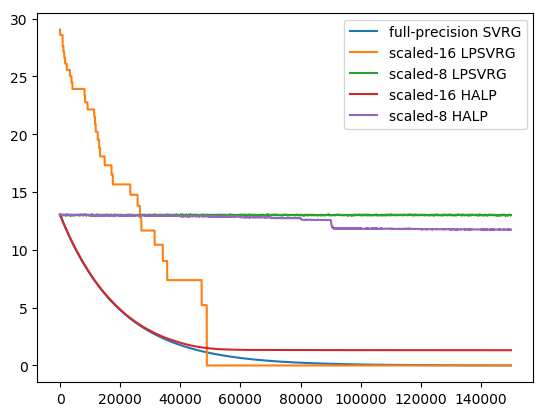

PyObject <matplotlib.legend.Legend object at 0x12ba03750>

In [12]:
(w,dto_svrg) = SVRG{alpha,N*10,15}(w0,wopt,X,Y,g_log_loss);
(w,dto_lpsvrg) = LPSVRG{alpha,N*10,15,B}(w0,wopt,X,Y,g_log_loss);
(w,dto_lpsvrg2) = LPSVRG{alpha,N*10,15,B2}(w0,wopt,X,Y,g_log_loss);
(w,dto_halp) = HALP{alpha,N*10,15,R}(w0,wopt,X,Y,mu,g_log_loss);
(w,dto_halp2) = HALP{alpha,N*10,15,R2}(w0,wopt,X,Y,mu,g_log_loss);
plot(dto_svrg;label="full-precision SVRG")
plot(dto_lpsvrg;label="scaled-16 LPSVRG")
plot(dto_lpsvrg2;label="scaled-8 LPSVRG")
plot(dto_halp;label="scaled-16 HALP")
plot(dto_halp2;label="scaled-8 HALP")
legend()

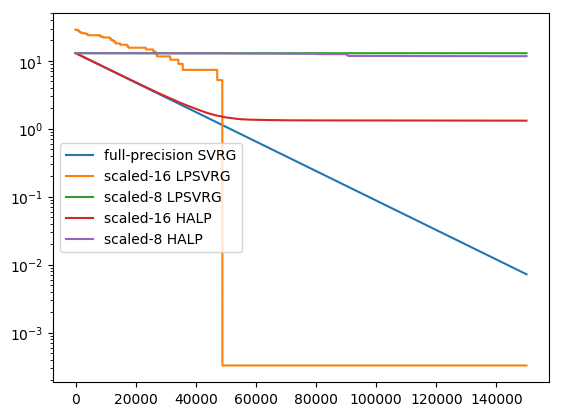

PyObject <matplotlib.legend.Legend object at 0x12bf6fa10>

In [13]:
semilogy(dto_svrg;label="full-precision SVRG")
semilogy(dto_lpsvrg;label="scaled-16 LPSVRG")
semilogy(dto_lpsvrg2;label="scaled-8 LPSVRG")
semilogy(dto_halp;label="scaled-16 HALP")
semilogy(dto_halp2;label="scaled-8 HALP")
legend()

In [14]:
# Gradient for Logistic Regression
halp_g_log_loss = ((p, Y) -> (-Y ./ (1 + exp.(Y .* p))) / length(Y))

(::#17) (generic function with 1 method)

In [35]:
blue = 8;
purple = 8;
alpha = 0.0005;
mu = 1/.100;
tol = 1.0;

In [36]:
(w,dto_lmhalp) = LMHALP{alpha,N,8,B}(w0,wopt,X,Y,blue,purple,mu,tol,halp_g_log_loss);

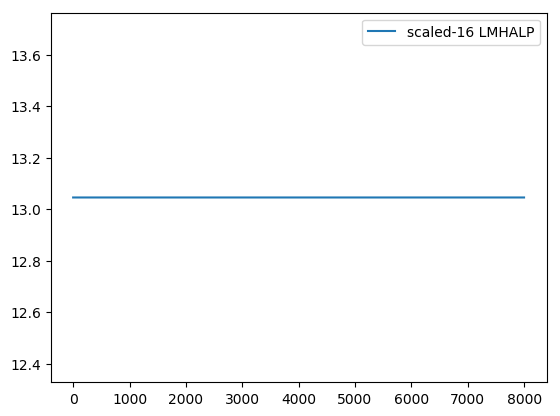

PyObject <matplotlib.legend.Legend object at 0x110f178d0>

In [37]:
plot(dto_lmhalp;label="scaled-16 LMHALP")
legend()